# Практика 3.5: градиентный бустинг по деревьям в `sklearn`

В предыдущих тетрадках мы:

- разобрали, как работает дерево решений (классификация и регрессия);
- посмотрели на `DecisionTreeClassifier` / `DecisionTreeRegressor` в `sklearn`;
- изучили случайный лес (`RandomForest`) как ансамбль деревьев, обучаемых **независимо** (бэггинг).

Теперь наша цель — понять **градиентный бустинг по деревьям**:

- что такое бустинг и чем он отличается от бэггинга;
- как работает **градиентный** бустинг на уровне алгоритма;
- как это реализовано в `GradientBoostingClassifier` и `GradientBoostingRegressor`;
- как влияют гиперпараметры (`n_estimators`, `learning_rate`, `max_depth` базовых деревьев);
- как выглядит динамика обучения и переобучение.

Мы будем идти от **интуиции** → к **алгоритму** → к **коду и визуализациям**.


In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_moons, make_classification
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor, RandomForestClassifier
from sklearn.metrics import accuracy_score, mean_squared_error

plt.rcParams["figure.figsize"] = (7, 5)
plt.rcParams["axes.grid"] = True


## 1. Бэггинг vs бустинг: интуиция

### 1.1. Бэггинг (например, случайный лес)

Бэггинг (**bagging**, bootstrap aggregating):

1. Строим много моделей (**деревьев**) **независимо** друг от друга.
2. Каждое дерево обучаем на своей bootstrap-выборке (случайная подвыборка с возвращением).
3. При предсказании:
   - в классификации — **голосование большинства**;
   - в регрессии — **усреднение** предсказаний деревьев.

Цель: уменьшить **дисперсию** модели (variance).  
Каждое отдельное дерево может переобучаться, но их среднее даёт более устойчивый результат.

Схема (упрощённо):

- входные данные → много деревьев параллельно → усреднение/голосование → итоговое предсказание.

### 1.2. Бустинг

Бустинг — другая логика:

1. Строим модели **последовательно**.
2. Каждая следующая модель обучается на **ошибках** текущего ансамбля.
3. Итоговое предсказание — взвешенная сумма предсказаний всех моделей.

Интуитивно:

- первый базовый алгоритм даёт грубое приближение;
- второй «подправляет» ошибки первого;
- третий «подправляет» то, что не исправлено первыми двумя;
- и так далее.

Цель: уменьшить **смещение** (bias) — сделать модель более гибкой и точной, по чуть-чуть дообучая её на остатках.

Схема:

- начальная простая модель → последовательное добавление маленьких «правок» → итоговый ансамбль.

### 1.3. От бустинга к градиентному бустингу

Бустинг можно реализовать по-разному.  
**Градиентный бустинг** формализует эту идею через **градиентный спуск по функции потерь**.

Идея:

- мы хотим найти функцию $f(x)$, минимизирующую суммарную потерю
  $$
  \sum_{i=1}^n L(y_i, f(x_i)),
  $$
  как в обычной регрессии/классификации;
- но вместо одного «большого» алгоритма мы строим **аддитивную модель** — сумму простых моделей (деревьев):
  $$
  f_M(x) = \sum_{m=1}^M \eta \, h_m(x),
  $$
  где $h_m(x)$ — $m$-е базовое дерево (weak learner), $\eta$ — `learning_rate`;
- на каждом шаге мы добавляем новое дерево $h_m$, которое пытается «двинуть нас» в сторону уменьшения функции потерь — т.е. вдоль **отрицательного градиента**.

Это и есть **градиентный спуск**, но не по вектору параметров, а по функции: мы шагаем в пространстве функций, добавляя всё новые и новые деревья.


## 2. Градиентный бустинг для регрессии: алгоритм

Начнём с регрессии и квадратичной функции потерь.

### 2.1. Модель

Будем искать модель в виде суммы деревьев регрессии:

$$
f_M(x) = f_0(x) + \sum_{m=1}^M \eta \, h_m(x),
$$

где:
- $f_0(x)$ — начальная простая модель (обычно константа);
- $h_m(x)$ — $m$-е дерево регрессии (**слабый алгоритм**);
- $\eta \in (0, 1]$ — шаг (параметр `learning_rate`);
- $M = \text{n\_estimators}$ — число шагов (число деревьев).

### 2.2. Функция потерь

Для регрессии возьмём привычную **MSE** (среднеквадратичную ошибку):

$$
L(y, f(x)) = \frac{1}{2}(y - f(x))^2.
$$

Мы хотим минимизировать суммарную ошибку по всем объектам:

$$
\mathcal{L}(f) = \sum_{i=1}^n L(y_i, f(x_i)).
$$

### 2.3. Градиент по предсказаниям

Посчитаем производную потери по предсказанию $f(x_i)$ (а не по параметрам!):

$$
\frac{\partial L(y_i, f(x_i))}{\partial f(x_i)}
= \frac{\partial}{\partial f(x_i)} \frac{1}{2} (y_i - f(x_i))^2
= -(y_i - f(x_i)).
$$

Отрицательный градиент равен **остаткам**:

$$
- \frac{\partial L}{\partial f(x_i)} = y_i - f(x_i).
$$

То есть для MSE **антиградиент = настоящие остатки**.

### 2.4. Алгоритм (регрессия, MSE)

Для заданных данных $(x_i, y_i)$:

1. Инициализация:
   - выбираем начальную константу
     $$
     f_0(x) = \arg\min_c \sum_{i=1}^n L(y_i, c)
     $$
     Для MSE это просто среднее:
     $$
     f_0(x) = \bar{y} = \frac{1}{n} \sum_{i=1}^n y_i.
     $$

2. Для $m = 1, 2, \dots, M$:
   1. Считаем текущие предсказания:
      $$
      \hat{y}_i^{(m-1)} = f_{m-1}(x_i).
      $$
   2. Вычисляем **псевдо-остатки** (для MSE это реальные остатки):
      $$
      r_i^{(m)} = y_i - \hat{y}_i^{(m-1)}.
      $$
   3. Обучаем новое дерево $h_m(x)$ **предсказывать эти остатки**:
      $$
      h_m = \arg\min_h \sum_{i=1}^n (r_i^{(m)} - h(x_i))^2.
      $$
   4. (Опционально) подбираем коэффициент $\gamma_m$ (line search; для простоты можно взять $\gamma_m = 1$):
      $$
      \gamma_m = \arg\min_\gamma \sum_{i=1}^n L\bigl(y_i, f_{m-1}(x_i) + \gamma h_m(x_i)\bigr).
      $$
   5. Обновляем модель:
      $$
      f_m(x) = f_{m-1}(x) + \eta \, \gamma_m h_m(x).
      $$

3. Итоговая модель: $f_M(x)$.

**Главная идея:** на каждом шаге мы строим дерево, которое лучше всего приближает **ошибки текущей модели**, и добавляем его с маленьким шагом.

В общем случае (для других функций потерь) на шаге 2.2 мы берём **отрицательный градиент** потерь по $f(x_i)$, а не буквально остатки — отсюда и название *градиентный* бустинг.


## 3. Демонстрация: градиентный бустинг для регрессии (1D)

Сначала рассмотрим простую одномерную задачу регрессии:

- истинная функция: $y = \sin x + 0.5 \cos(2x)$;
- добавим шум;
- сравним:
  - одиночное дерево регрессии,
  - градиентный бустинг по деревьям,
  - и посмотрим, как бустинг «приближается» к истинной функции шаг за шагом.


In [2]:
# Одномерная регрессионная задача
rng = np.random.RandomState(42)

X_reg = np.linspace(0, 10, 200).reshape(-1, 1)
y_true = np.sin(X_reg[:, 0]) + 0.5 * np.cos(2 * X_reg[:, 0])
y_reg = y_true + rng.normal(scale=0.4, size=X_reg.shape[0])

Xr_train, Xr_test, yr_train, yr_test = train_test_split(
    X_reg, y_reg, test_size=0.3, random_state=42
)

Xr_train.shape, Xr_test.shape


((140, 1), (60, 1))

In [13]:
# Одиночное дерево регрессии
tree_reg = DecisionTreeRegressor(
    max_depth=2,
    random_state=42
)
tree_reg.fit(Xr_train, yr_train)

# Градиентный бустинг для регрессии
gbr = GradientBoostingRegressor(
    n_estimators=300,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)
gbr.fit(Xr_train, yr_train)

yr_pred_tree = tree_reg.predict(Xr_test)
yr_pred_gbr = gbr.predict(Xr_test)

print("DecisionTreeRegressor:")
print("  MSE:", mean_squared_error(yr_test, yr_pred_tree))

print("\nGradientBoostingRegressor:")
print("  MSE:", mean_squared_error(yr_test, yr_pred_gbr))


DecisionTreeRegressor:
  MSE: 0.24687570721357333

GradientBoostingRegressor:
  MSE: 0.2556132257936616


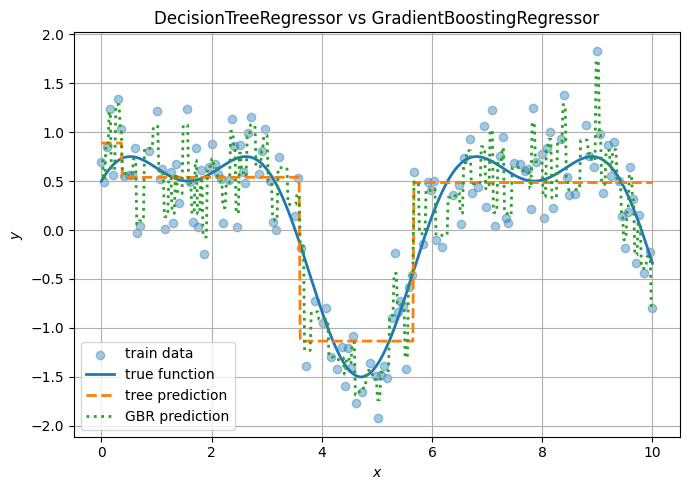

In [14]:
# Визуализация предсказаний
X_plot = np.linspace(0, 10, 500).reshape(-1, 1)
y_true_plot = np.sin(X_plot[:, 0]) + 0.5 * np.cos(2 * X_plot[:, 0])
y_tree_plot = tree_reg.predict(X_plot)
y_gbr_plot = gbr.predict(X_plot)

fig, ax = plt.subplots()
ax.scatter(Xr_train[:, 0], yr_train, alpha=0.4, label="train data")
ax.plot(X_plot[:, 0], y_true_plot, linewidth=2, label="true function")
ax.plot(X_plot[:, 0], y_tree_plot, linewidth=2, linestyle="--", label="tree prediction")
ax.plot(X_plot[:, 0], y_gbr_plot, linewidth=2, linestyle=":", label="GBR prediction")
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
ax.set_title("DecisionTreeRegressor vs GradientBoostingRegressor")
ax.legend()
plt.tight_layout()
plt.show()


Что видно на графике:

- **дерево регрессии** даёт кусочно-постоянную функцию, легко «подхватывает» шум, имеет резкие ступеньки;
- **градиентный бустинг** по деревьям даёт более гладкую аппроксимацию, лучше следует истинной функции;
- по MSE на тесте бустинг обычно выигрывает у одиночного дерева.

Дальше посмотрим, как ансамбль **эволюционирует по шагам**.


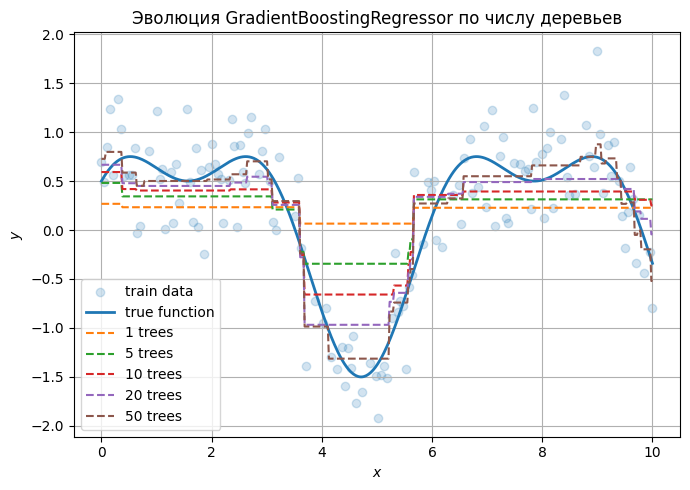

In [5]:
# Показ нескольких промежуточных стадий бустинга
gbr_small = GradientBoostingRegressor(
    n_estimators=50,
    learning_rate=0.1,
    max_depth=2,
    random_state=42
)
gbr_small.fit(Xr_train, yr_train)

n_plots = [1, 5, 10, 20, 50]  # номера итераций (число деревьев)

X_plot = np.linspace(0, 10, 500).reshape(-1, 1)
y_true_plot = np.sin(X_plot[:, 0]) + 0.5 * np.cos(2 * X_plot[:, 0])

# staged_predict даёт предсказания после добавления каждого дерева
staged_preds = list(gbr_small.staged_predict(X_plot))

fig, ax = plt.subplots()
ax.scatter(Xr_train[:, 0], yr_train, alpha=0.2, label="train data")
ax.plot(X_plot[:, 0], y_true_plot, linewidth=2, label="true function")

for n in n_plots:
    y_stage = staged_preds[n-1]
    ax.plot(X_plot[:, 0], y_stage, linestyle="--", linewidth=1.5,
            label=f"{n} trees")

ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
ax.set_title("Эволюция GradientBoostingRegressor по числу деревьев")
ax.legend()
plt.tight_layout()
plt.show()


На этом графике видно, как бустинг **постепенно улучшает** аппроксимацию:

- первые несколько деревьев дают грубое приближение к реальной функции;
- по мере увеличения числа деревьев кривая всё лучше «попадает» в истинный тренд;
- при слишком большом числе деревьев (особенно при большом `learning_rate`) модель может начать подстраиваться под шум — **переобучение**.

Теперь перейдём к классификации и рассмотрим поведение градиентного бустинга на `make_moons`.


## 4. Градиентный бустинг для классификации (интуитивно)

В классификации всё чуть сложнее математически, но идея та же:

- мы всё так же строим аддитивную модель
  $$
  f_M(x) = \sum_{m=1}^M \eta \, h_m(x),
  $$
  где $h_m(x)$ — небольшие деревья (например, глубины 2–3);
- но функция потерь — уже **логистическая** (для бинарной классификации) или её обобщение.

Для бинарной классификации можно думать так:

- $f(x)$ — это **логит** (значение до сигмоиды);
- вероятность класса $1$:
  $$
  p(x) = \sigma(f(x)) = \frac{1}{1 + e^{-f(x)}};
  $$
- функция потерь — логистическая (binary cross-entropy):
  $$
  L(y, f(x)) = - \bigl( y \log p(x) + (1-y) \log (1-p(x)) \bigr).
  $$

На каждом шаге:

1. считаем текущие предсказания логитов $f_{m-1}(x_i)$ (внутри алгоритма);
2. считаем отрицательный градиент логистической потери по $f$ — это **псевдо-остатки**;
3. обучаем новое дерево $h_m$ предсказывать эти псевдо-остатки;
4. добавляем его к ансамблю: $f_m(x) = f_{m-1}(x) + \eta h_m(x)$.

В `sklearn.GradientBoostingClassifier` вся эта математика скрыта внутри — нам нужно лишь выбрать `loss="log_loss"` (по умолчанию) и задать параметры ансамбля.


In [6]:
def plot_decision_boundary(model, X, y, h=0.02, title=None):
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

    xx, yy = np.meshgrid(
        np.arange(x_min, x_max, h),
        np.arange(y_min, y_max, h)
    )
    grid = np.c_[xx.ravel(), yy.ravel()]
    Z = model.predict(grid)
    Z = Z.reshape(xx.shape)

    fig, ax = plt.subplots()
    ax.contourf(xx, yy, Z, alpha=0.2)
    ax.scatter(X[:, 0], X[:, 1], c=y, edgecolor="k", alpha=0.8)
    ax.set_xlabel("$x_1$")
    ax.set_ylabel("$x_2$")
    if title is not None:
        ax.set_title(title)
    plt.show()


## 5. `GradientBoostingClassifier` vs дерево и случайный лес

Возьмём знакомый датасет `make_moons` и сравним три модели:

1. одиночное дерево (`DecisionTreeClassifier`);
2. случайный лес (`RandomForestClassifier`);
3. градиентный бустинг (`GradientBoostingClassifier`).

Посмотрим на качество и границы решений.


In [7]:
# Датасет make_moons
X, y = make_moons(n_samples=400, noise=0.25, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

X_train.shape, X_test.shape


((280, 2), (120, 2))

In [8]:
# Одиночное дерево
tree_clf = DecisionTreeClassifier(
    max_depth=None,
    random_state=42
)
tree_clf.fit(X_train, y_train)

# Случайный лес
rf_clf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)
rf_clf.fit(X_train, y_train)

# Градиентный бустинг
gb_clf = GradientBoostingClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)
gb_clf.fit(X_train, y_train)

models = [("Tree", tree_clf), ("RandomForest", rf_clf), ("GradientBoosting", gb_clf)]

for name, model in models:
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    print(f"{name}:")
    print("  Accuracy (train):", accuracy_score(y_train, y_pred_train))
    print("  Accuracy (test): ", accuracy_score(y_test, y_pred_test))
    print()


Tree:
  Accuracy (train): 1.0
  Accuracy (test):  0.9083333333333333

RandomForest:
  Accuracy (train): 1.0
  Accuracy (test):  0.9166666666666666

GradientBoosting:
  Accuracy (train): 1.0
  Accuracy (test):  0.9



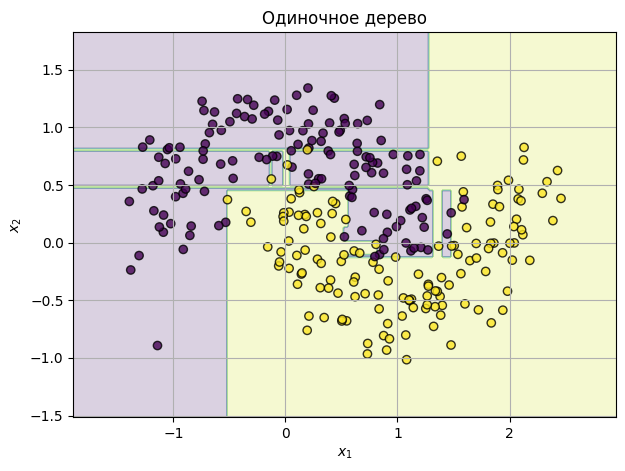

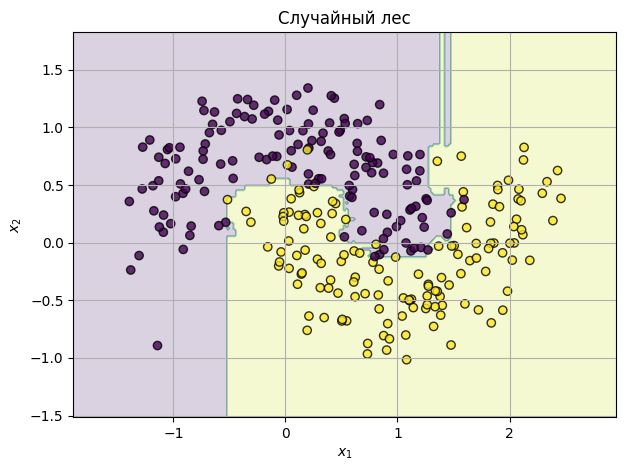

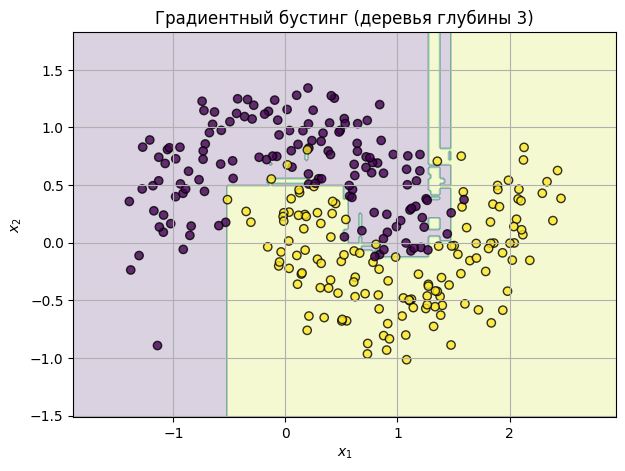

In [9]:
plot_decision_boundary(tree_clf, X_train, y_train,
                        title="Одиночное дерево")

plot_decision_boundary(rf_clf, X_train, y_train,
                        title="Случайный лес")

plot_decision_boundary(gb_clf, X_train, y_train,
                        title="Градиентный бустинг (деревья глубины 3)")


Наблюдения:

- **одиночное дерево** легко переобучается (почти идеально на train, хуже на test), граница решений «зубчатая»;
- **случайный лес** сглаживает границу благодаря усреднению множества деревьев;
- **градиентный бустинг** часто даёт высокое качество на тесте с достаточно гладкой границей, но при увеличении числа деревьев и глубины может начать **сильно переобучаться**, если не контролировать `learning_rate`.

Дальше посмотрим, как влияют `n_estimators`, `learning_rate` и глубина базовых деревьев.


## 6. Влияние `n_estimators` и `learning_rate` (классификация)

Посмотрим, как меняется тестовое качество при разных комбинациях `learning_rate` и `n_estimators`.


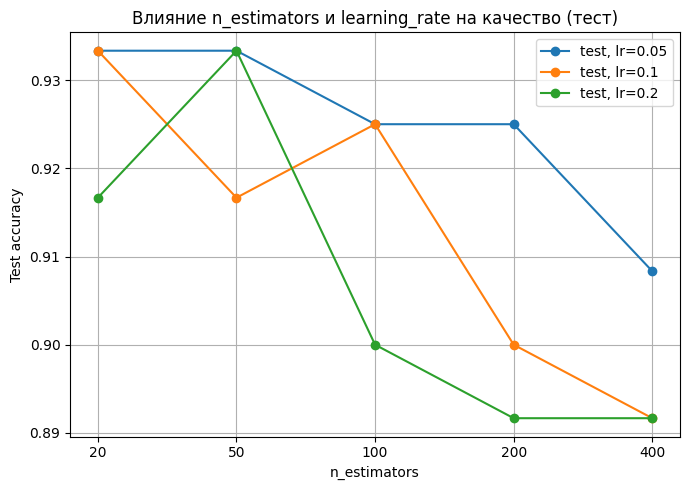

In [10]:
learning_rates = [0.05, 0.1, 0.2]
n_estimators_list = [20, 50, 100, 200, 400]

results = []

for lr in learning_rates:
    train_scores = []
    test_scores = []
    for n in n_estimators_list:
        gb_tmp = GradientBoostingClassifier(
            n_estimators=n,
            learning_rate=lr,
            max_depth=3,
            random_state=42
        )
        gb_tmp.fit(X_train, y_train)
        y_tr_pred = gb_tmp.predict(X_train)
        y_te_pred = gb_tmp.predict(X_test)
        train_scores.append(accuracy_score(y_train, y_tr_pred))
        test_scores.append(accuracy_score(y_test, y_te_pred))
    results.append((lr, train_scores, test_scores))

fig, ax = plt.subplots()
x_ticks = list(range(len(n_estimators_list)))
labels = [str(n) for n in n_estimators_list]

for lr, train_scores, test_scores in results:
    ax.plot(x_ticks, test_scores, marker="o", label=f"test, lr={lr}")

ax.set_xticks(x_ticks)
ax.set_xticklabels(labels)
ax.set_xlabel("n_estimators")
ax.set_ylabel("Test accuracy")
ax.set_title("Влияние n_estimators и learning_rate на качество (тест)")
ax.legend()
plt.tight_layout()
plt.show()


Типичное поведение:

- для каждого `learning_rate` есть диапазон `n_estimators`, где тестовое качество максимальное;
- при слишком малом числе деревьев модель недообучена;
- при слишком большом — начинает переобучаться (особенно при большом `learning_rate`).

На практике:
- `learning_rate` часто берут в диапазоне $0.01$–$0.1$;
- `n_estimators` подбирают по валидации, а не «на глаз».


## 7. Глубина базовых деревьев в классификации

Теперь посмотрим, как влияет глубина базовых деревьев `max_depth` в `GradientBoostingClassifier` на make_moons.


max_depth = 1
  Accuracy (train): 0.9571428571428572
  Accuracy (test):  0.9166666666666666



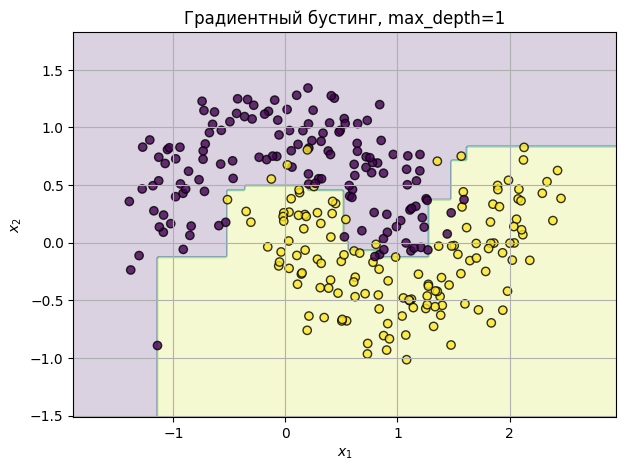

max_depth = 2
  Accuracy (train): 1.0
  Accuracy (test):  0.9083333333333333



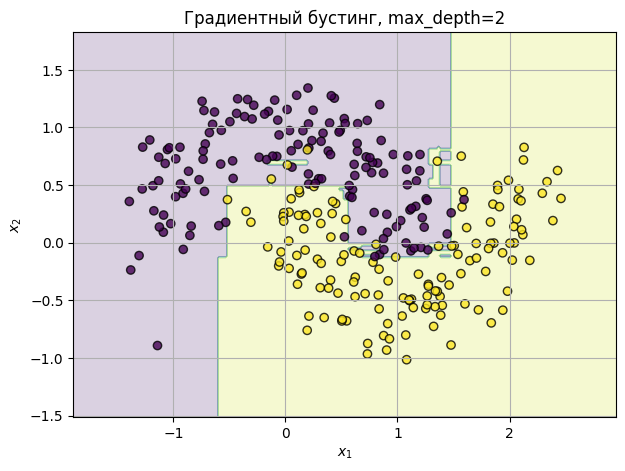

max_depth = 3
  Accuracy (train): 1.0
  Accuracy (test):  0.9



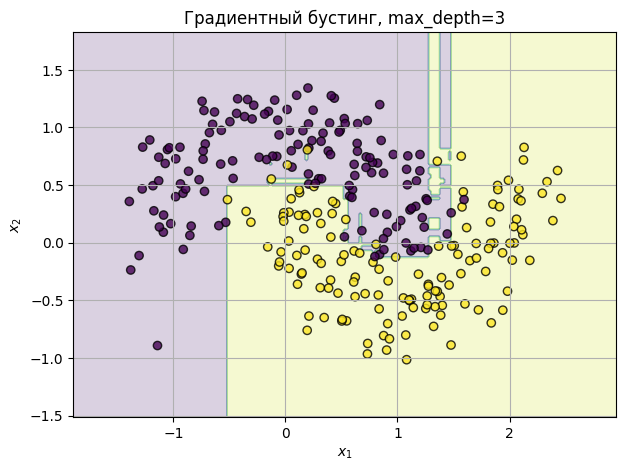

max_depth = 5
  Accuracy (train): 1.0
  Accuracy (test):  0.9083333333333333



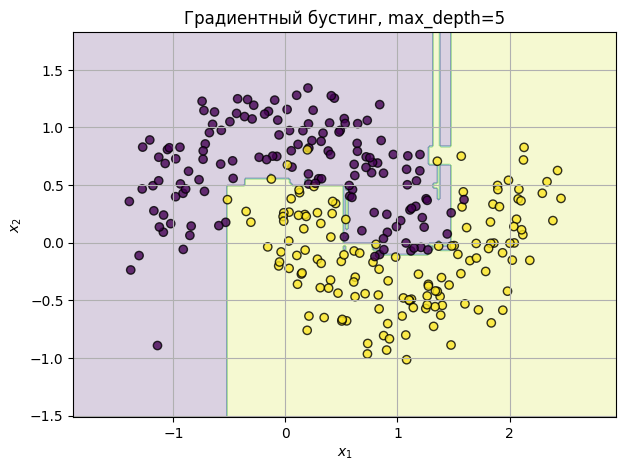

In [11]:
depths = [1, 2, 3, 5]

for d in depths:
    gb_depth = GradientBoostingClassifier(
        n_estimators=200,
        learning_rate=0.1,
        max_depth=d,
        random_state=42
    )
    gb_depth.fit(X_train, y_train)
    y_tr_pred = gb_depth.predict(X_train)
    y_te_pred = gb_depth.predict(X_test)

    print(f"max_depth = {d}")
    print("  Accuracy (train):", accuracy_score(y_train, y_tr_pred))
    print("  Accuracy (test): ", accuracy_score(y_test, y_te_pred))
    print()

    title = f"Градиентный бустинг, max_depth={d}"
    plot_decision_boundary(gb_depth, X_train, y_train, title=title)


Наблюдения:

- при `max_depth = 1` (decision stumps) ансамбль может недообучаться;
- при `max_depth = 2`–`3` ансамбль достаточно гибкий и часто показывает хорошее качество;
- при `max_depth = 5` и выше ансамбль быстро подстраивается под шум → при большом `n_estimators` переобучение усиливается.

На практике базовые деревья в бустинге обычно делают **неглубокими**: глубина 2–5, иногда ограничивают по `max_leaf_nodes`.


## 8. Динамика обучения: `staged_predict`

Чтобы увидеть, где ансамбль начинает переобучаться, полезно смотреть динамику качества по мере добавления деревьев.

Используем `staged_predict`:
- на каждом шаге $m$ получаем предсказания ансамбля из первых $m$ деревьев;
- считаем accuracy на train и test.


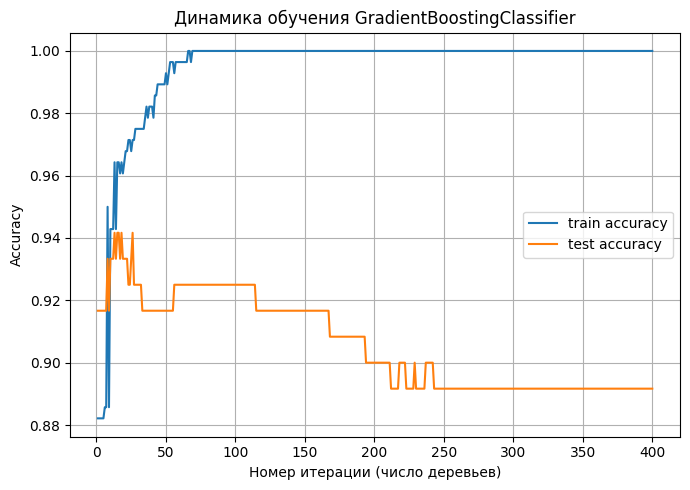

In [12]:
gb_monitor = GradientBoostingClassifier(
    n_estimators=400,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)
gb_monitor.fit(X_train, y_train)

train_scores = []
test_scores = []

for y_tr_pred in gb_monitor.staged_predict(X_train):
    train_scores.append(accuracy_score(y_train, y_tr_pred))

for y_te_pred in gb_monitor.staged_predict(X_test):
    test_scores.append(accuracy_score(y_test, y_te_pred))

iters = np.arange(1, len(train_scores) + 1)

fig, ax = plt.subplots()
ax.plot(iters, train_scores, label="train accuracy")
ax.plot(iters, test_scores, label="test accuracy")
ax.set_xlabel("Номер итерации (число деревьев)")
ax.set_ylabel("Accuracy")
ax.set_title("Динамика обучения GradientBoostingClassifier")
ax.legend()
plt.tight_layout()
plt.show()


На такой кривой обычно видно:

- обучающее качество растёт и может достигать $1.0$;
- тестовое качество сначала растёт, достигает максимума, затем может снижаться — признак переобучения по числу деревьев.

Эту кривую можно использовать для подбора разумного `n_estimators`:
- выбрать число деревьев, при котором тестовое качество (или качество на валидации) максимальное;
- не обязательно использовать все деревья, на которые была настроена модель.


## 9. Итоги: ключевые идеи градиентного бустинга по деревьям

1. **Аддитивная модель**
   $$
   f_M(x) = f_0(x) + \sum_{m=1}^M \eta \, h_m(x),
   $$
   где $h_m(x)$ — маленькие деревья, а $\eta$ — `learning_rate`.

2. **Градиент по функции потерь**
   - в регрессии с MSE на каждом шаге мы подгоняем деревья под **остатки**;
   - в классификации с логистической потерей — под **псевдо-градиенты** по логитам.

3. **Отличие от случайного леса**
   - лес: деревья строятся **независимо**, усредняются → в основном снижается дисперсия;
   - бустинг: деревья строятся **последовательно**, исправляют ошибки → снижается смещение.

4. **Регулировка сложности и переобучения**
   - `learning_rate`: чем меньше, тем «осторожнее» шаги и дольше можно наращивать деревья;
   - `n_estimators`: чем больше, тем сложнее модель, выше риск переобучения;
   - `max_depth` / `max_leaf_nodes`: сложность базовых деревьев;
   - также важны `min_samples_leaf`, `min_samples_split` и другие параметры регуляризации дерева.

5. **Практика**
   - на табличных данных градиентный бустинг по деревьям — один из самых сильных базовых методов;
   - в курсе достаточно понимать:
     - общую идею «суммы деревьев»,
     - связь с градиентным спуском по функции потерь,
     - влияние основных гиперпараметров и типичное поведение кривых обучения.

Связка идей курса:

**линейная/логистическая регрессия → дерево → случайный лес (бэггинг) → градиентный бустинг (последовательное исправление ошибок)**.

Дальше эти модели можно использовать как сильные базовые алгоритмы в практических проектах по анализу данных и соревнованиях.
